### Analytics Vidhya - HackLive 3 - 71.05% LB Score- Rank 50 Simple Transformers and Classifier Chains - Solution

In [1]:
## Reference - AV Guided Hack Session.

PROBLEM STATEMENT

Topic Modeling for Research Articles 2.0 Researchers have access to large online archives of scientific articles. As a consequence, finding relevant articles has become more and more difficult. Tagging or topic modelling provides a way to give clear token of identification to research articles which facilitates recommendation and search process.

Earlier on the Independence Day we conducted a Hackathon to predict the topics for each article included in the test set. Continuing with the same problem, In this Live Hackathon we will take one more step ahead and predict the tags associated with the articles.

Given the abstracts for a set of research articles, predict the tags for each article included in the test set. Note that a research article can possibly have multiple tags. The research article abstracts are sourced from the following 4 topics:

Computer Science

Mathematics

Physics

Statistics

List of possible tags are as follows:

[Tags, Analysis of PDEs, Applications, Artificial Intelligence,Astrophysics of Galaxies, Computation and Language, Computer Vision and Pattern Recognition, Cosmology and Nongalactic Astrophysics, Data Structures and Algorithms, Differential Geometry, Earth and Planetary Astrophysics, Fluid Dynamics,Information Theory, Instrumentation and Methods for Astrophysics, Machine Learning, Materials Science, Methodology, Number Theory, Optimization and Control, Representation Theory, Robotics, Social and Information Networks, Statistics Theory, Strongly Correlated Electrons, Superconductivity, Systems and Control]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from lightgbm import LGBMRegressor

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings
warnings.simplefilter('ignore')

from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import GaussianNB
from scipy.sparse import csr_matrix

## Read the data and basic EDA

In [3]:
train = pd.read_csv('../input/topic-modeling-for-research-articles-20/Train.csv')
test = pd.read_csv('../input/topic-modeling-for-research-articles-20/Test.csv')
ss = pd.read_csv('../input/topic-modeling-for-research-articles-20/SampleSubmission.csv')
tags = pd.read_csv('../input/topic-modeling-for-research-articles-20/Tags.csv')
path = "./"

In [4]:
ID_COL = 'id'

TARGET_COLS = ['Analysis of PDEs', 'Applications',
               'Artificial Intelligence', 'Astrophysics of Galaxies',
               'Computation and Language', 'Computer Vision and Pattern Recognition',
               'Cosmology and Nongalactic Astrophysics',
               'Data Structures and Algorithms', 'Differential Geometry',
               'Earth and Planetary Astrophysics', 'Fluid Dynamics',
               'Information Theory', 'Instrumentation and Methods for Astrophysics',
               'Machine Learning', 'Materials Science', 'Methodology', 'Number Theory',
               'Optimization and Control', 'Representation Theory', 'Robotics',
               'Social and Information Networks', 'Statistics Theory',
               'Strongly Correlated Electrons', 'Superconductivity',
               'Systems and Control']

TOPIC_COLS = ['Computer Science', 'Mathematics', 'Physics', 'Statistics']

In [5]:
train.head(3)
test.head(3)
tags.head(3)

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,1824,a ever-growing datasets inside observational a...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3094,we propose the framework considering optimal $...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8463,nanostructures with open shell transition meta...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics
0,9409,fundamental frequency (f0) approximation from ...,0,0,0,1
1,17934,"this large-scale study, consisting of 24.5 mil...",1,0,0,1
2,16071,we present a stability analysis of the plane c...,0,0,1,0


,Tags
0,Analysis of PDEs
1,Applications
2,Artificial Intelligence


In [6]:
print(f'\n->->->| Train contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\n->->->| Test contains {test.shape[0]} samples and {test.shape[1]} variables')
print(f'\n->->->| Number of distinct SUB TOPICS is {len(TARGET_COLS)}')

features = [c for c in train.columns if c not in [ID_COL] + TARGET_COLS]
print(f'\n->->->| The dataset contains {len(features)} features')


->->->| Train contains 14004 samples and 31 variables

->->->| Test contains 6002 samples and 6 variables

->->->| Number of distinct SUB TOPICS is 25

->->->| The dataset contains 5 features


* ### Target Distribution

In [7]:
len(TARGET_COLS)

25

In [8]:
100 * (train[TARGET_COLS].sum()/(train.shape[0])).sort_values(ascending=False)

Machine Learning                                27.313625
Artificial Intelligence                          9.825764
Robotics                                         6.812339
Computer Vision and Pattern Recognition          6.705227
Strongly Correlated Electrons                    6.376750
Materials Science                                5.534133
Computation and Language                         4.605827
Cosmology and Nongalactic Astrophysics           4.520137
Optimization and Control                         4.434447
Social and Information Networks                  4.420166
Analysis of PDEs                                 4.334476
Applications                                     4.227364
Astrophysics of Galaxies                         4.098829
Methodology                                      4.098829
Systems and Control                              4.041702
Differential Geometry                            3.963153
Superconductivity                                3.870323
Statistics The

In [9]:
# Null Values
null_values_per_variable = 100 * (train.isnull().sum()/train.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

Systems and Control                             0.0
Differential Geometry                           0.0
ABSTRACT                                        0.0
Computer Science                                0.0
Mathematics                                     0.0
Physics                                         0.0
Statistics                                      0.0
Analysis of PDEs                                0.0
Applications                                    0.0
Artificial Intelligence                         0.0
Astrophysics of Galaxies                        0.0
Computation and Language                        0.0
Computer Vision and Pattern Recognition         0.0
Cosmology and Nongalactic Astrophysics          0.0
Data Structures and Algorithms                  0.0
Earth and Planetary Astrophysics                0.0
Superconductivity                               0.0
Fluid Dynamics                                  0.0
Information Theory                              0.0
Instrumentat

In [10]:
train[TOPIC_COLS].sum().sort_values(ascending=False)

Computer Science    5884
Physics             3856
Statistics          3794
Mathematics         2831
dtype: int64

In [11]:
100 * (train[TARGET_COLS].sum()/(train.shape[0])).sort_values(ascending=False)

Machine Learning                                27.313625
Artificial Intelligence                          9.825764
Robotics                                         6.812339
Computer Vision and Pattern Recognition          6.705227
Strongly Correlated Electrons                    6.376750
Materials Science                                5.534133
Computation and Language                         4.605827
Cosmology and Nongalactic Astrophysics           4.520137
Optimization and Control                         4.434447
Social and Information Networks                  4.420166
Analysis of PDEs                                 4.334476
Applications                                     4.227364
Astrophysics of Galaxies                         4.098829
Methodology                                      4.098829
Systems and Control                              4.041702
Differential Geometry                            3.963153
Superconductivity                                3.870323
Statistics The

In [12]:
from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(stopwords = set(list(STOPWORDS) + ['inside']), random_state = 42)

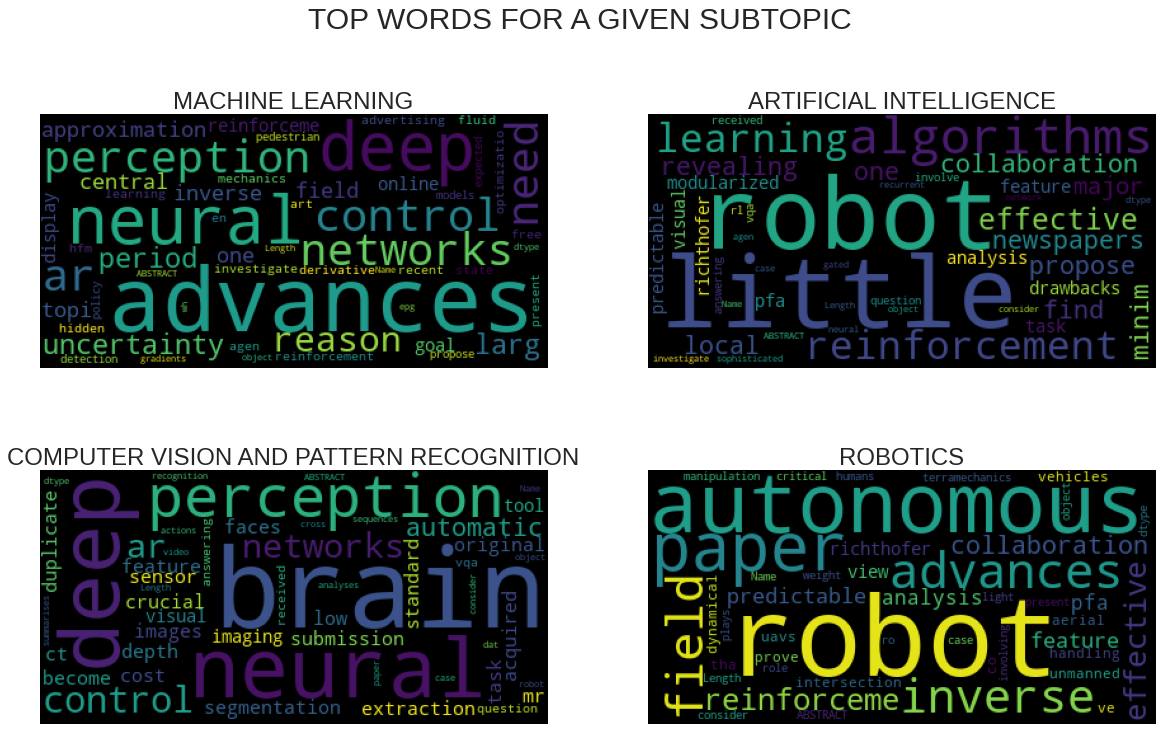

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]
for i, sub_topic_name in enumerate(['Machine Learning', 'Artificial Intelligence', 'Computer Vision and Pattern Recognition', 'Robotics']):
    sub_topic = train[train[sub_topic_name] == 1]
    op = wc.generate(str(sub_topic['ABSTRACT']))
    _ = axes[i].imshow(op)
    _ = axes[i].set_title(sub_topic_name.upper(), fontsize=24)
    _ = axes[i].axis('off')
    
_ = plt.suptitle('TOP WORDS FOR A GIVEN SUBTOPIC', fontsize=30)

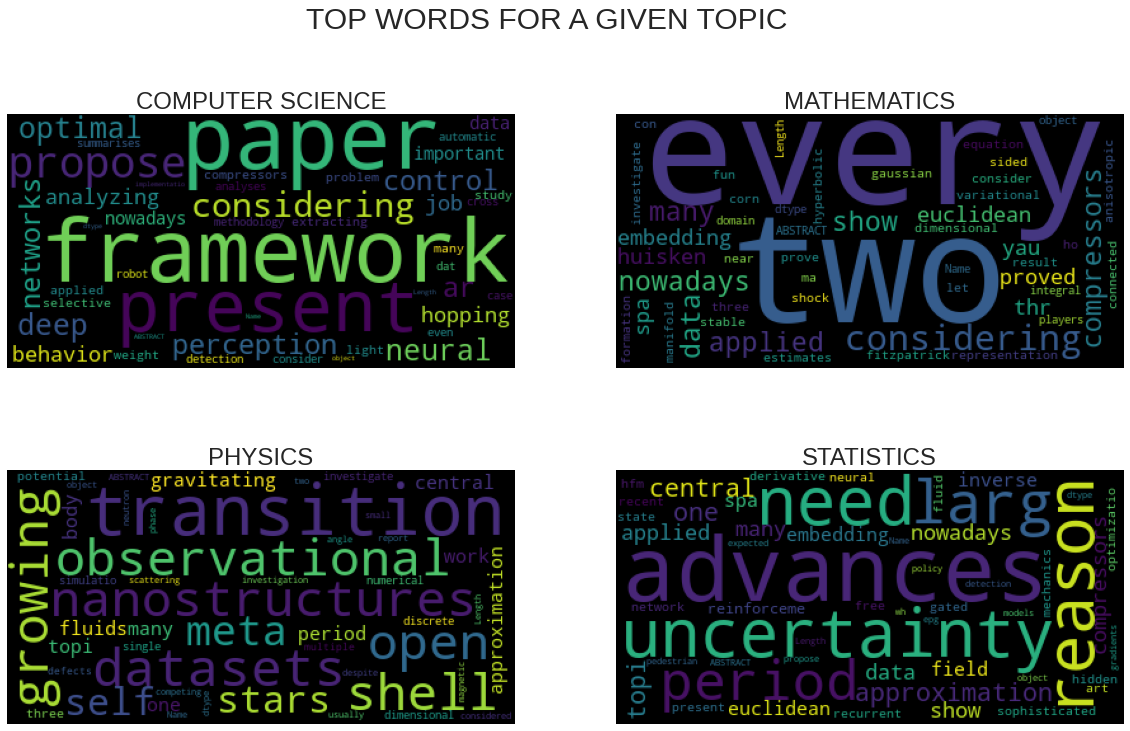

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]
for i, sub_topic_name in enumerate(TOPIC_COLS):
    sub_topic = train[train[sub_topic_name] == 1]
    op = wc.generate(str(sub_topic['ABSTRACT']))
    _ = axes[i].imshow(op)
    _ = axes[i].set_title(sub_topic_name.upper(), fontsize=24)
    _ = axes[i].axis('off')
_ = plt.suptitle('TOP WORDS FOR A GIVEN TOPIC', fontsize=30)

## MODEL BUILDING

In [15]:
!pip install --upgrade transformers 

     |████████████████████████████████| 1.3 MB 596 kB/s 
     |████████████████████████████████| 2.9 MB 3.1 MB/s 
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.8.1rc1
    Uninstalling tokenizers-0.8.1rc1:
      Successfully uninstalled tokenizers-0.8.1rc1
  Attempting uninstall: transformers
    Found existing installation: transformers 3.0.2
    Uninstalling transformers-3.0.2:
      Successfully uninstalled transformers-3.0.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

allennlp 1.1.0 requires transformers<3.1,>=3.0, but you'll have transformers 3.4.0 which is incompatible.


In [16]:
!pip install --upgrade simpletransformers 

     |████████████████████████████████| 214 kB 594 kB/s 
     |████████████████████████████████| 7.4 MB 7.9 MB/s 
     |████████████████████████████████| 43 kB 1.4 MB/s 
     |████████████████████████████████| 70 kB 5.7 MB/s 
     |████████████████████████████████| 4.5 MB 13.3 MB/s 
     |████████████████████████████████| 120 kB 18.6 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16170 sha256=bee6c15ed142e4df90e5a8115a9db62f06ffdb05a23d7365ea606a5d5807b650
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: cachetools
    Found existing installation: cachetools 3.1.1
    Uninstalling cachetools-3.1.1:
      Successfully uninstalled cachetools-3.1.1
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.1.1
    Uninstalling ipykernel-5.1.1:
      Successfully uninstalled ipykernel-5.1.1
  Attempting uninstall: tqdm
    Found e

In [17]:
train['labels'] = list(zip(train['Analysis of PDEs'].tolist(),
                        train['Applications'].tolist(),
                        train['Artificial Intelligence'].tolist(),
                        train['Astrophysics of Galaxies'].tolist(),
                        train['Computation and Language'].tolist(),
                        train['Computer Vision and Pattern Recognition'].tolist(),
                        train['Cosmology and Nongalactic Astrophysics'].tolist(),
                        train['Data Structures and Algorithms'].tolist(),
                        train['Differential Geometry'].tolist(),
                        train['Earth and Planetary Astrophysics'].tolist(),
                        train['Fluid Dynamics'].tolist(),
                        train['Information Theory'].tolist(),
                        train['Instrumentation and Methods for Astrophysics'].tolist(),
                        train['Machine Learning'].tolist(),
                        train['Materials Science'].tolist(),
                        train['Methodology'].tolist(),
                        train['Number Theory'].tolist(),
                        train['Optimization and Control'].tolist(),
                        train['Representation Theory'].tolist(),
                        train['Robotics'].tolist(),
                        train['Social and Information Networks'].tolist(),
                        train['Statistics Theory'].tolist(),
                        train['Strongly Correlated Electrons'].tolist(),
                        train['Superconductivity'].tolist(),
                        train['Systems and Control'].tolist()
                        ))
train['text'] = train['ABSTRACT'].apply(lambda x: x.replace('\n', ' '))
cols = ['text','labels']

In [18]:
trn, val = train_test_split(train, test_size=0.22, random_state=2000)

In [19]:
# preprocessing
def preprocess(text):
    processed_text =text.str.replace(r'\d+(\.\d+)?', 'numbr')
    # Remove punctuation
    processed_text = processed_text.str.replace(r'[^\w\d\s]', ' ')
    
    # Replace whitespace between terms with a single space
    processed_text = processed_text.str.replace(r'\s+', ' ')
    
    # Remove leading and trailing whitespace
    processed_text = processed_text.str.replace(r'^\s+|\s+?$', '')
    
    # change words to lower case - Hello, HELLO, hello are all the same word
    processed_text = processed_text.str.lower()
    
    return processed_text

#processed_text  = preprocess(all_text)

def get_texts(df):
    #texts = df['ABSTRACT'].apply(preprocess)
    df['ABSTRACT'] = preprocess(df['ABSTRACT'])
    #texts = texts.values.tolist()
    return df

In [20]:
import torch, gc
train = get_texts(train)
test = get_texts(test)

trn = get_texts(trn)
val = get_texts(val)

cols = ['text','labels']


gc.collect()
torch.cuda.empty_cache()

6291

## Simple Transformers

In [21]:
%%time
from simpletransformers.classification import MultiLabelClassificationModel
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

train_df = pd.DataFrame(trn[cols]) #pd.DataFrame(trn[cols], columns=[cols])
eval_df = pd.DataFrame(val[cols])

# Use bert-large-cased with 5 epochs - Kaggle Disk space goes out with large cased.

# Create a MultiLabelClassificationModel
model = MultiLabelClassificationModel('bert', 'bert-base-cased', num_labels=25, args={'reprocess_input_data': True, 
                                                                                      'gradient_accumulation_steps':16, 'learning_rate': 3e-5, 
                                                                                      'max_seq_length': 128,
                                                                                     'overwrite_output_dir': True, 'num_train_epochs': 3})
# Train the model
model.train_model(train_df[cols]) #,eval_df=eval_df[cols])

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not in



CPU times: user 8min 31s, sys: 14.8 s, total: 8min 45s
Wall time: 10min 46s


(255, 0.244567474123894)

In [22]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)
result

{'LRAP': 0.5473156140756202, 'eval_loss': 0.17501350148663003}

In [23]:
def get_best_thresholds(true, preds):
    thresholds = [i/100 for i in range(100)]
    best_thresholds = []
    for idx in range(25):
        f1_scores = [f1_score(true[:, idx], (preds[:, idx] > thresh) * 1) for thresh in thresholds]
        best_thresh = thresholds[np.argmax(f1_scores)]
    
        best_thresholds.append(best_thresh)
    return best_thresholds

In [24]:
best_thresholds = get_best_thresholds(val[TARGET_COLS].values, model_outputs)
best_thresholds
for i, thresh in enumerate(best_thresholds):
    model_outputs[:, i] = (model_outputs[:, i] > thresh) * 1

f1_score(val[TARGET_COLS], model_outputs, average='micro')

[0.1,
 0.1,
 0.16,
 0.12,
 0.1,
 0.09,
 0.15,
 0.07,
 0.17,
 0.1,
 0.06,
 0.0,
 0.07,
 0.36,
 0.16,
 0.09,
 0.1,
 0.1,
 0.12,
 0.13,
 0.07,
 0.1,
 0.21,
 0.17,
 0.06]

0.3080840918942349

In [25]:
to_predict = test.ABSTRACT.apply(lambda x: x.replace('\n', ' ')).tolist()
preds, outputs = model.predict(to_predict)
outputs_p = outputs

# Save the probabilities to blend later
pd.DataFrame(outputs,columns=TARGET_COLS).to_csv(path + 'Simple_transformers_Prob.csv')

for i, thresh in enumerate(best_thresholds):
    outputs[:, i] = (outputs[:, i] > thresh) * 1

In [26]:
# Download file function
def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [27]:
create_download_link(ss, filename = 'hacklive_fastai.csv')

## Classifier Chains and Logistic Regression

In [28]:
!pip install scikit-multilearn

In [29]:
vec = CountVectorizer(max_features=10000)
_ = vec.fit(list(train['ABSTRACT']) + list(test['ABSTRACT']))

trn_abs = vec.transform(trn['ABSTRACT'])
val_abs = vec.transform(val['ABSTRACT'])
tst_abs = vec.transform(test['ABSTRACT'])
print(trn_abs.shape, val_abs.shape, tst_abs.shape)

trn2 = np.hstack((trn_abs.toarray(), trn[TOPIC_COLS]))
val2 = np.hstack((val_abs.toarray(), val[TOPIC_COLS]))
tst2 = np.hstack((tst_abs.toarray(), test[TOPIC_COLS]))

print(trn2.shape, val2.shape, tst2.shape)

(10923, 10000) (3081, 10000) (6002, 10000)
(10923, 10004) (3081, 10004) (6002, 10004)


In [30]:
trn2 = csr_matrix(trn2.astype('int16'))
val2 = csr_matrix(val2.astype('int16'))
tst2 = csr_matrix(tst2.astype('int16'))

In [31]:

# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
classifier = ClassifierChain(LogisticRegression(C = 12, n_jobs=-1))

# train
print('Start Training...')
classifier.fit(trn2, trn[TARGET_COLS])

# predict
print('Start Predicting...')
val_preds = classifier.predict_proba(val2)

val_preds = val_preds.toarray()
best_thresholds = get_best_thresholds(val[TARGET_COLS].values, val_preds)

Start Training...


ClassifierChain(classifier=LogisticRegression(C=12, n_jobs=-1),
                require_dense=[True, True])

Start Predicting...


In [32]:
val_preds = classifier.predict_proba(val2)
best_thresholds = get_best_thresholds(val[TARGET_COLS].values, val_preds.toarray())
val_preds = val_preds.toarray()

In [33]:
for i, thresh in enumerate(best_thresholds):
    val_preds[:, i] = (val_preds[:, i] > thresh) * 1

f1_score(val[TARGET_COLS], val_preds, average='micro')

0.7258522727272728

In [34]:
preds_test = classifier.predict_proba(tst2)
preds_test = preds_test.toarray()
preds_test_p = preds_test

for i, thresh in enumerate(best_thresholds):
    preds_test[:, i] = (preds_test[:, i] > thresh) * 1

ss[TARGET_COLS] = preds_test
create_download_link(ss, filename = 'hacklive_NLP_count_added_topics_ClassifierChain1.csv')

## Ensemble

In [35]:
p1 = pd.DataFrame(outputs_p,columns=TARGET_COLS)
p2 = pd.DataFrame(preds_test_p,columns=TARGET_COLS)

In [36]:
preds_test_Fin = p1
for label in TARGET_COLS:
    preds_test_Fin[label] = (0.40*p1[label])+(0.60*p2[label])

In [37]:
for i, thresh in enumerate(best_thresholds):
  #print("COL : " + str(i))
  preds_test_Fin.iloc[:,i] =  (preds_test_Fin.iloc[:,i] > 0.25) * 1

ss[TARGET_COLS] = preds_test
create_download_link(ss, filename = 'hacklive_NLP_count_added_topics_ClassifierChain1.csv')

In [38]:
ss.to_csv("submission.csv")

In [39]:
# finish